In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def ppca(X, latent_dim):
    """
    Probabilistic PCA implementation using EM algorithm.

    Parameters:
        X (numpy.ndarray): Observed X of shape (n, d).
        latent_dim (int): Dimensionality of the latent space.
        max_iter (int): Maximum number of iterations for the EM algorithm.
        tol (float): Convergence tolerance for parameter updates.

    Returns:
        W (numpy.ndarray): Weight matrix of shape (n, latent_dim).
        sigma2 (float): Variance of the isotropic noise.
        mu (numpy.ndarray): Mean of the X of shape (d,).
        X (numpy.ndarray): Latent variable estimates of shape (n, latent_dim).

    The algorithm based on the appendix of A.5 of our friend Bishop.
    """
    n, d = X.shape

    mu = np.mean(X, axis=0)
    centered_data = X - mu
    W = np.random.randn(d, latent_dim)
    sigma2 = 1.0

    max_iter = 100
    tol = 1e-6

    for iteration in range(max_iter):
        # E-step
        M = W.T @ W + sigma2 * np.eye(latent_dim)
        M_inv = np.linalg.inv(M)
        Ez = centered_data @ W @ M_inv
        Ezz = sigma2 * M_inv + Ez.T @ Ez

        # M-step
        W_new = (centered_data.T @ Ez) @ np.linalg.inv(Ezz)
        sigma2_new = (1 / (n * d)) * (
            np.sum(centered_data**2)
            - 2 * np.trace((centered_data @ W_new) @ Ez.T)
            + np.trace(Ezz @ W_new.T @ W_new)
        )

        if np.allclose(W, W_new) and np.allclose(sigma2, sigma2_new):
            break

        W, sigma2 = W_new, sigma2_new

    M = W.T @ W + sigma2 * np.eye(latent_dim)
    M_inv = np.linalg.inv(M)
    X = centered_data @ W @ M_inv

    return W, sigma2, mu, X


def kernel_pca_direct(K, l):
    """
    Direct implementation of Kernel PCA like in the paper.

    Parameters:
    -----------
    K : ndarray of shape (n, n)
        Kernel matrix computed from abstract data points X_1, ..., X_n
    l : int
        Number of components to keep (ℓ in the algorithm)
    """
    n = K.shape[0]

    ones_n = np.ones((n, n)) / n
    K_tilde = K - ones_n @ K - K @ ones_n + ones_n @ K @ ones_n

    eigenvalues, A = np.linalg.eigh(K_tilde)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    A = A[:, idx]

    eigenvalues = eigenvalues[:l]
    A = A[:, :l]

    scaling = 1.0 / np.sqrt(np.maximum(eigenvalues, 1e-8))
    V_l = A * scaling

    y = np.zeros((n, l))
    for i in range(n):
        for s in range(l):
            y[i, s] = np.sum(V_l[:, s] * K_tilde[i, :])

    return y



In [ ]:
def make_rbf_kernel(X, Y=None, gamma=1.0):
    """
    Compute RBF (Gaussian) kernel matrix.
    K(x,y) = exp(-gamma * ||x-y||^2)

    Parameters:
    -----------
    X : array of shape (n_samples_X, n_features)
    Y : array of shape (n_samples_Y, n_features), optional
    gamma : float, default=1.0
        Inverse of standard deviation

    Returns:
    --------
    K : array of shape (n_samples_X, n_samples_Y)
        Kernel matrix
    """
    if Y is None:
        Y = X

    sq_dists = (np.sum(X**2, axis=1).reshape(-1, 1) +
               np.sum(Y**2, axis=1) -
               2 * np.dot(X, Y.T))
    return np.exp(-gamma * sq_dists)

def make_polynomial_kernel(X, Y=None, degree=3, gamma=1.0, coef0=1.0):
    """
    Compute polynomial kernel matrix.
    K(x,y) = (gamma * <x,y> + coef0)^degree

    Parameters:
    -----------
    X : array-like of shape (n_samples_X, n_features)
    Y : array-like of shape (n_samples_Y, n_features), optional
    degree : int, default=3
        Degree of the polynomial kernel
    gamma : float, default=1.0
        Scale parameter
    coef0 : float, default=1.0
        Independent term

    Returns:
    --------
    K : array-like of shape (n_samples_X, n_samples_Y)
        Kernel matrix
    """
    if Y is None:
        Y = X

    return (gamma * np.dot(X, Y.T) + coef0) ** degree

def make_sde_kernel(X, Y=None, sigma=1.0, rho=1.0):
    """
    Compute SDE (Strain Dependent Elasticity) kernel matrix.
    K(x,y) = exp(-||x-y||^2/(2*sigma^2)) * (1 + ||x-y||^2/(2*rho^2))

    Parameters:
    -----------
    X : array-like of shape (n_samples_X, n_features)
    Y : array-like of shape (n_samples_Y, n_features), optional
    sigma : float, default=1.0
        Length scale parameter
    rho : float, default=1.0
        Elasticity parameter

    Returns:
    --------
    K : array-like of shape (n_samples_X, n_samples_Y)
        Kernel matrix
    this is based on Ali Ghodsi's paper.
    """
    if Y is None:
        Y = X
        dists = squareform(pdist(X))
    else:
        dists = np.sqrt(np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2))

    K = np.exp(-dists**2 / (2 * sigma**2))
    K = K * (1 + dists**2 / (2 * rho**2))

    return K


def make_ard_kernel(X, Y=None, length_scales=None):
    """
    Compute ARD (Automatic Relevance Determination) squared exponential kernel matrix.
    K(x,y) = exp(-0.5 * Σ((x_d - y_d)^2 / length_scales_d^2))

    Parameters:
    -----------
    X : array of shape (n_samples_X, n_features)
        First set of input samples
    Y : array of shape (n_samples_Y, n_features), optional
        Second set of input samples. If None, use X
    length_scales : array of shape (n_features,), optional
        Length scales for each feature dimension.
        If None, defaults to ones(n_features)

    Returns:
    --------
    K : array of shape (n_samples_X, n_samples_Y)
        Kernel matrix
    Will be used for Bayesian optimization.
    """
    X = np.array(X)
    n_features = X.shape[1]

    if length_scales is None:
        length_scales = np.ones(n_features)
    length_scales = np.array(length_scales).reshape(1, -1)

    if Y is None:
        Y = X
    else:
        Y = np.array(Y)

    X_scaled = X / length_scales
    Y_scaled = Y / length_scales

    sq_dists = (np.sum(X_scaled**2, axis=1).reshape(-1, 1) +
               np.sum(Y_scaled**2, axis=1) -
               2 * np.dot(X_scaled, Y_scaled.T))

    K = np.exp(-0.5 * sq_dists)

    return K


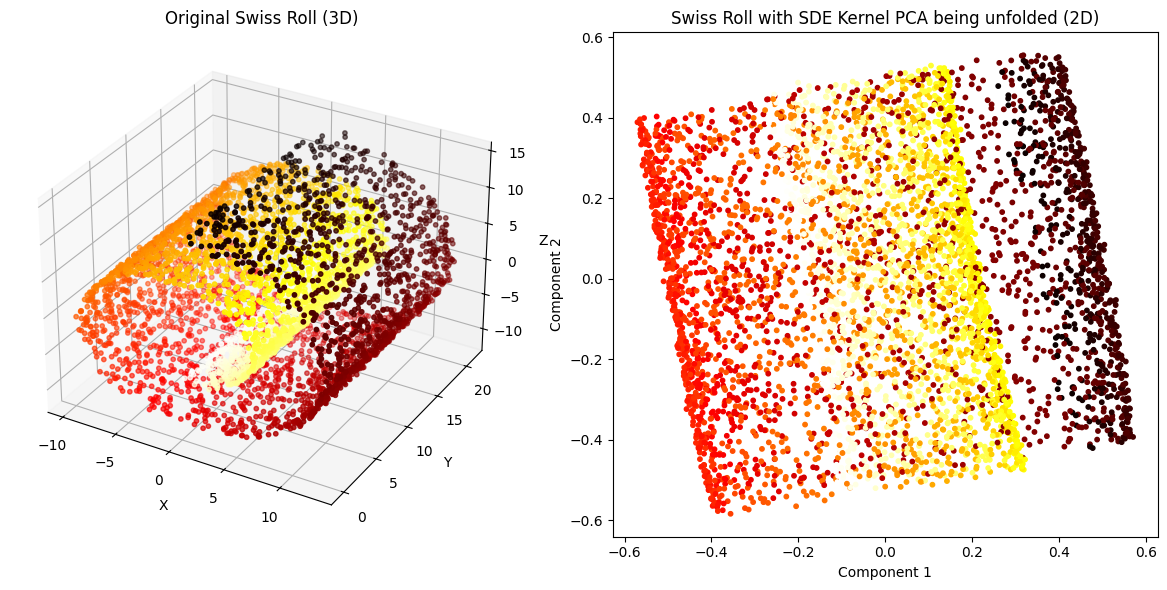

In [ ]:
#testing the KPCA and the different kernels
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import StandardScaler

n_samples = 5000
X, t = make_swiss_roll(n_samples=n_samples, noise=0.1, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sigma = 2.0 # the best
rho = 2.0 # the best
K_sde = make_sde_kernel(X_scaled, sigma=sigma, rho=rho)

l_components = 2
y_sde = kernel_pca_direct(K_sde, l=l_components)

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t,s=10, cmap="hot_r")
ax.set_title("Original Swiss Roll (3D)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")


ax2 = fig.add_subplot(122)
ax2.scatter(y_sde[:, 0], y_sde[:, 1], c=t,s=10 , cmap="hot_r")
ax2.set_title("Swiss Roll with SDE Kernel PCA being unfolded (2D)")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

plt.tight_layout()
plt.show()


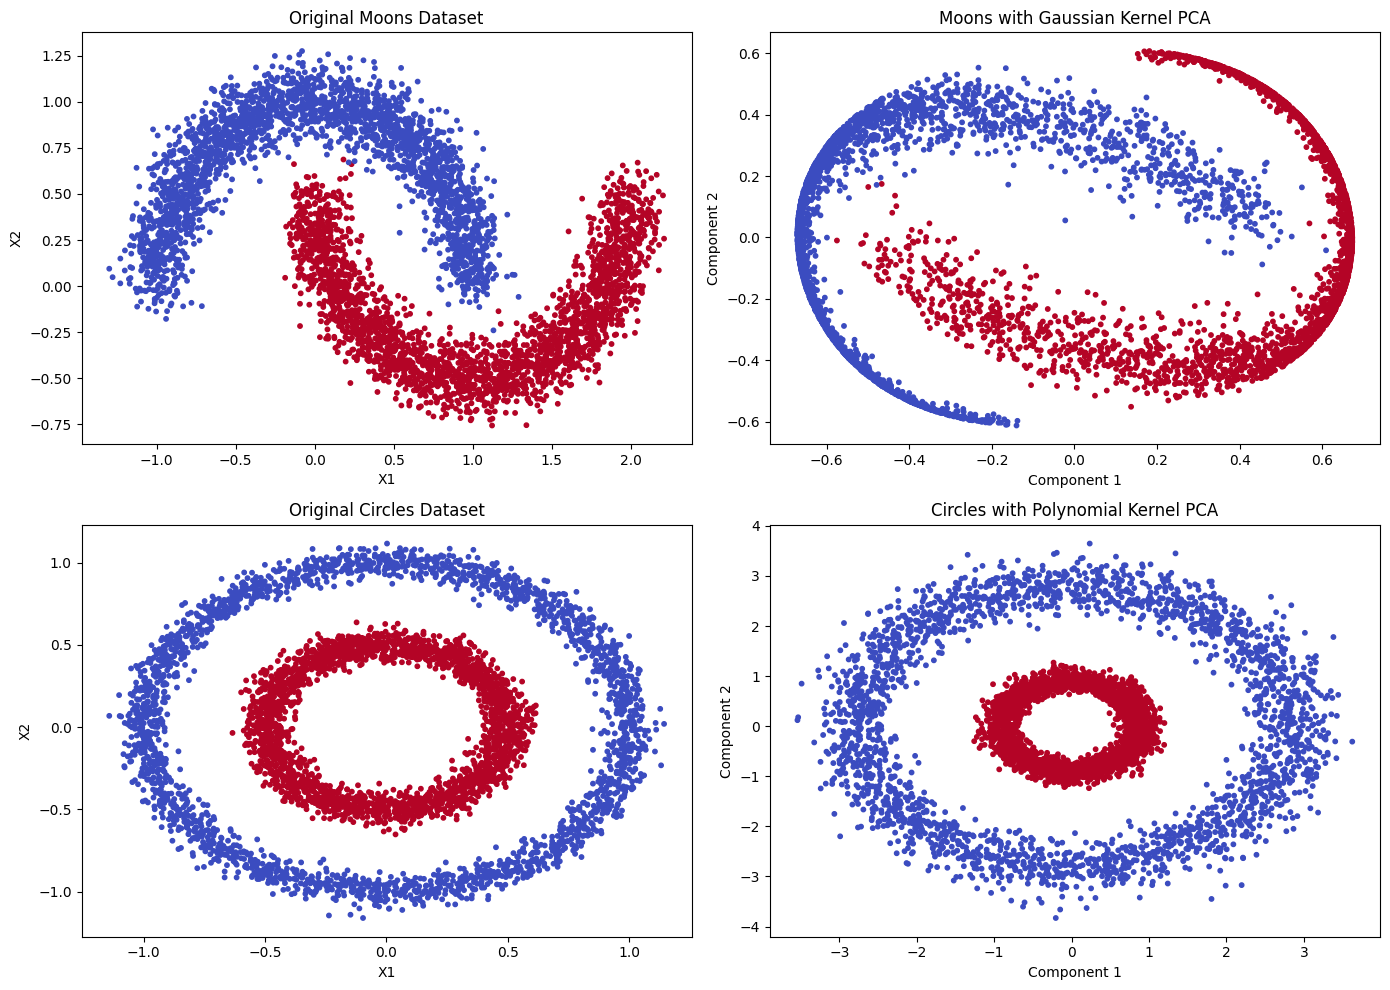

In [ ]:
#playing around with KPCA
from sklearn.datasets import make_moons
X_moons, t_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
X_moons_scaled = scaler.fit_transform(X_moons)


from sklearn.datasets import make_circles
X_circles, t_circles = make_circles(n_samples=n_samples, noise=0.05, factor=0.5, random_state=42)
X_circles_scaled = scaler.fit_transform(X_circles)


gamma = 0.25 # the best is the marge between blue and red
degree = 5


K_rbf_moons = make_rbf_kernel(X_moons_scaled, gamma=gamma)
y_rbf_moons = kernel_pca_direct(K_rbf_moons, l=l_components)


K_poly_circles = make_polynomial_kernel(X_circles_scaled, degree=degree, gamma=gamma)
y_poly_circles = kernel_pca_direct(K_poly_circles, l=l_components)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))


axes[0, 0].scatter(X_moons[:, 0], X_moons[:, 1], c=t_moons, s=10, cmap="coolwarm")
axes[0, 0].set_title("Original Moons Dataset")
axes[0, 0].set_xlabel("X1")
axes[0, 0].set_ylabel("X2")


axes[0, 1].scatter(y_rbf_moons[:, 0], y_rbf_moons[:, 1], c=t_moons, s=10, cmap="coolwarm")
axes[0, 1].set_title("Moons with Gaussian Kernel PCA")
axes[0, 1].set_xlabel("Component 1")
axes[0, 1].set_ylabel("Component 2")


axes[1, 0].scatter(X_circles[:, 0], X_circles[:, 1], c=t_circles, s=10, cmap="coolwarm")
axes[1, 0].set_title("Original Circles Dataset")
axes[1, 0].set_xlabel("X1")
axes[1, 0].set_ylabel("X2")


axes[1, 1].scatter(y_poly_circles[:, 0], y_poly_circles[:, 1], c=t_circles, s=10, cmap="coolwarm")
axes[1, 1].set_title("Circles with Polynomial Kernel PCA")
axes[1, 1].set_xlabel("Component 1")
axes[1, 1].set_ylabel("Component 2")

plt.tight_layout()
plt.show()


here we will impliment Bayesian optimization with Gaussian process prior for Kernel PCA and for that we will use the automatic relevance determination (ARD) squared exponential kernel.

$$K(x,y) _{\text{ARD}} =  \theta_0 \exp \left (\frac{-1}{2}r^2(x-y) \right) $$

where : $r^2(x-y) = \sum^d_{i=1}\frac{(x_i - y_i)^2}{\theta_i^2}$ and $\theta_i$'s are the hyperparameters. The algorithm will be

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

class GaussianProcess:
    def __init__(self, kernel_func, noise_level=1e-6):
        self.kernel_func = kernel_func
        self.noise_level = noise_level
        self.X_train = None
        self.y_train = None
        self.K = None
        self.K_inv = None

    def fit(self, X, y):
        """
        Fit Gaussian Process model to training data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training input samples
        y : array-like of shape (n_samples,)
            Target values
        """
        self.X_train = np.array(X)
        self.y_train = np.array(y)

        self.K = self.kernel_func(self.X_train)

        self.K += self.noise_level * np.eye(len(self.X_train))

        self.K_inv = np.linalg.inv(self.K)

    def predict(self, X_new):
        """
        Predict using the Gaussian process model.

        Parameters:
        -----------
        X_new : array-like of shape (n_samples_new, n_features)
            Query points where the GP is evaluated

        Returns:
        --------
        y_mean : array-like of shape (n_samples_new,)
            Mean of predictive distribution
        y_std : array-like of shape (n_samples_new,)
            Standard deviation of predictive distribution
        """
        K_star = self.kernel_func(self.X_train, X_new)
        K_star_star = self.kernel_func(X_new)

        y_mean = K_star.T @ self.K_inv @ self.y_train

        y_var = np.diag(K_star_star - K_star.T @ self.K_inv @ K_star)
        y_std = np.sqrt(np.maximum(y_var, 0))

        return y_mean, y_std

def expected_improvement(x, gp, y_best, xi=0.01):
    """
    Compute expected improvement acquisition function.

    Parameters:
    -----------
    x : array-like
        Point to evaluate EI at
    gp : GaussianProcess
        Fitted Gaussian Process model
    y_best : float
        Best observed value
    xi : float
        Exploration-exploitation trade-off parameter

    Returns:
    --------
    ei : float
        Expected improvement at x
    """
    x = x.reshape(1, -1)
    mu, sigma = gp.predict(x)

    if sigma <= 0:
        return 0

    z = (mu - y_best - xi) / sigma
    ei = (mu - y_best - xi) * norm.cdf(z) + sigma * norm.pdf(z)

    return ei

def bayesian_optimization(f, kernel, bounds, n_warmup=5, n_iter=30):
    """
    Bayesian optimization with Gaussian process prior.

    Parameters:
    -----------
    f : callable
        Objective function to minimize
    kernel : callable
        Kernel function for GP
    bounds : array-like of shape (n_features, 2)
        Bounds for each dimension of x
    n_warmup : int
        Number of random warmup points
    n_iter : int
        Number of optimization iterations

    Returns:
    --------
    x_best : array-like
        Location of best found value
    y_best : float
        Best found value
    """
    n_dims = len(bounds)
    bounds = np.array(bounds)

    gp = GaussianProcess(kernel)

    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_warmup, n_dims))
    y = np.array([f(x) for x in X])

    y_best = np.min(y)
    x_best = X[np.argmin(y)]

    for i in range(n_iter):
        gp.fit(X, y)

        def negative_ei(x):
            return -expected_improvement(x, gp, y_best)

        x_next = None
        ei_best = -1

        # random starts to avoid local optima
        n_restarts = 5
        for _ in range(n_restarts):
            x0 = np.random.uniform(bounds[:, 0], bounds[:, 1], size=n_dims)
            result = minimize(negative_ei, x0, bounds=bounds, method='L-BFGS-B') #found online

            if result.fun < -ei_best:
                x_next = result.x
                ei_best = -result.fun

        y_next = f(x_next)

        if y_next < y_best:
            y_best = y_next
            x_best = x_next

        X = np.vstack((X, x_next))
        y = np.append(y, y_next)

    return x_best, y_best

Drosophila of machine learning...
Optimization error: 61.17319751688887
Optimized kernel parameters: [9.63890315e-01 1.31634454e+00 1.72004030e+00 4.17959585e+00
 2.69693931e+00 4.32201841e-01 4.85796064e+00 3.27025800e+00
 4.39053744e+00 6.46759627e-01 4.29171219e+00 3.45310150e+00
 3.41854789e+00 3.49821797e+00 4.42000439e+00 2.83632021e+00
 2.93375970e+00 4.45603880e+00 2.44619206e+00 4.68747115e+00
 4.20287950e+00 6.69547164e-01 1.75920124e+00 2.75678455e+00
 1.91009622e+00 1.94163046e+00 2.70751597e-01 2.40566855e+00
 3.89695564e+00 3.26618273e+00 1.40627964e+00 4.25733236e-01
 2.71112073e+00 3.02061089e-01 9.68365149e-01 3.17991706e+00
 2.62045526e+00 2.50688340e+00 3.08410971e+00 7.01601067e-01
 4.35333159e+00 7.38694308e-01 1.42791343e+00 3.05709512e+00
 7.93324455e-01 4.57997639e+00 3.86481408e+00 4.46634814e+00
 2.93200761e+00 4.53213123e+00 9.32996468e-01 8.40372097e-01
 2.26567453e+00 2.11018695e+00 1.11175563e-01 4.21551861e+00
 4.37881924e+00 2.95610352e+00 1.51506656e+00

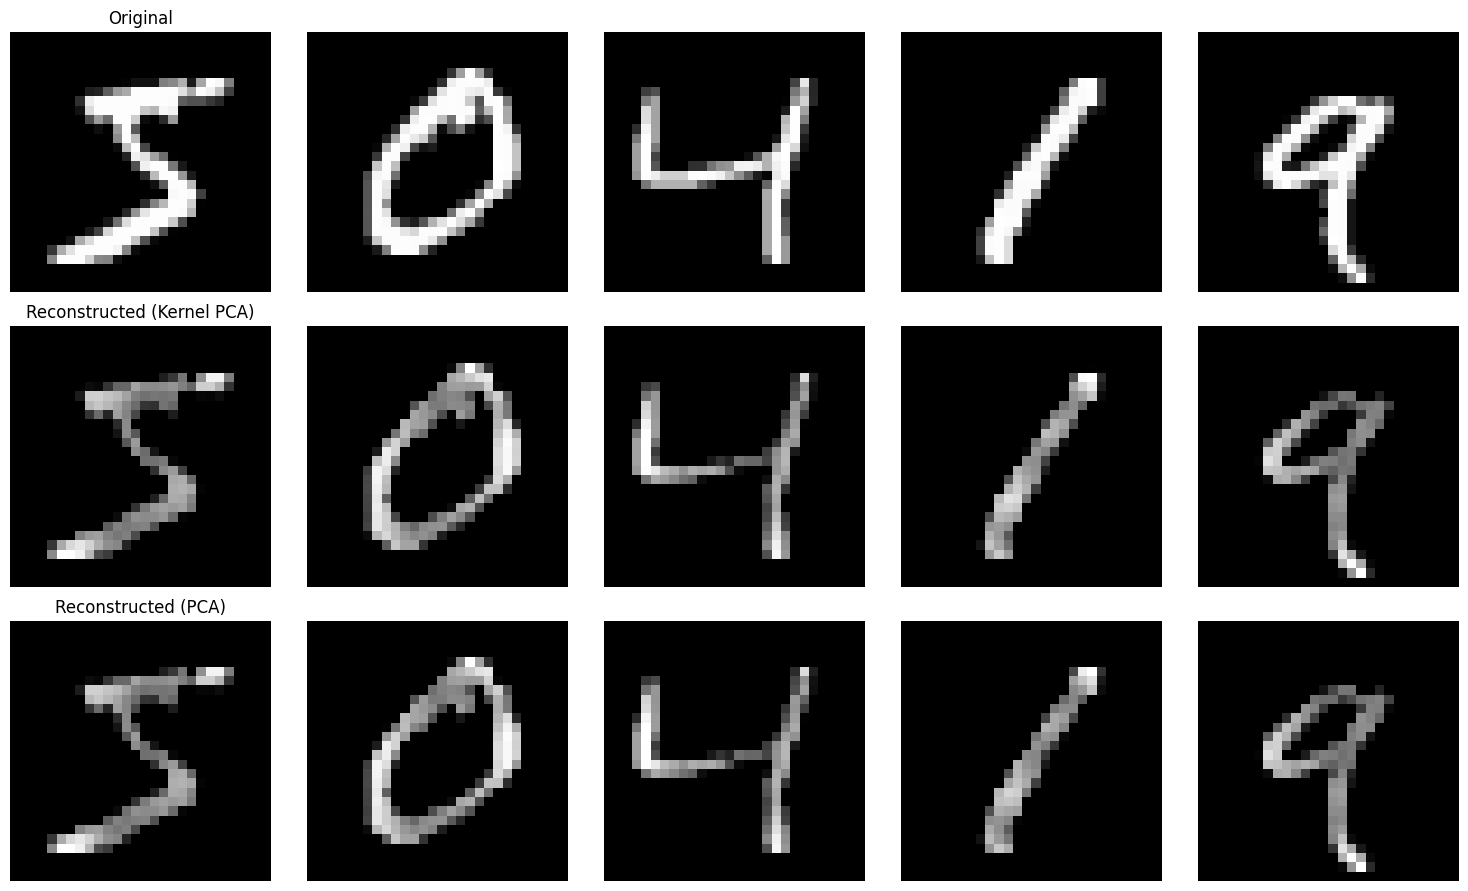

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

def preprocess_images(images):
    """
    Preprocess image data for Kernel PCA.
    """
    # Flatten images if not the case
    if len(images.shape) > 2:
        n_samples = images.shape[0]
        images = images.reshape(n_samples, -1)

    # Scale to [0, 1] range
    images = images.astype(float) / 255.0

    # Center the data
    scaler = StandardScaler(with_std=False)
    return scaler.fit_transform(images)

def reconstruct_kpca(K_test, V_l, K, eigenvalues):
    """
    Reconstruct data points from their Kernel PCA projections.
    Based on the pre-image problem solution.

    Parameters:
    -----------
    K_test : ndarray
        Kernel matrix between test points and training points
    V_l : ndarray
        Eigenvectors from kernel PCA
    K : ndarray
        Training kernel matrix
    eigenvalues : ndarray
        Eigenvalues from kernel PCA
    """
    n_train = K.shape[0]
    n_components = V_l.shape[1]

    # Center the kernel matrix
    ones_n = np.ones((n_train, n_train)) / n_train
    K_centered = K - ones_n @ K - K @ ones_n + ones_n @ K @ ones_n

    # Project test points
    gamma = np.zeros((K_test.shape[0], n_components))
    for i in range(n_components):
        gamma[:, i] = K_test @ V_l[:, i] / np.sqrt(max(eigenvalues[i], 1e-8))

    # using the kernel trick
    reconstruction = gamma @ (V_l.T @ K_centered)
    return reconstruction

def kpca_reconstruction_error(params, X, n_components=50):
    """
    Compute reconstruction error for Kernel PCA with given kernel parameters.
    Fixed to handle proper dimensionality of reconstructions.
    """
    if len(params.shape) == 0:
        K = make_rbf_kernel(X, gamma=float(params))
    else:
        K = make_ard_kernel(X, length_scales=params)

    try:
        n = K.shape[0]
        ones_n = np.ones((n, n)) / n
        K_centered = K - ones_n @ K - K @ ones_n + ones_n @ K @ ones_n
        eigenvalues, V = np.linalg.eigh(K_centered)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        V = V[:, idx]

        gamma = np.zeros((n, n_components))
        for i in range(n_components):
            gamma[:, i] = K @ V[:, i] / np.sqrt(max(eigenvalues[i], 1e-8))

        reconstruction = np.zeros_like(X)
        for i in range(n):
            weights = gamma[i, :n_components] @ V[:, :n_components].T
            reconstruction[i] = np.sum(weights.reshape(-1, 1) * X, axis=0)

        error = np.mean((X - reconstruction) ** 2)

        regularization = 0.01 * np.sum(params ** 2)

        return error + regularization

    except np.linalg.LinAlgError:
        return 1e6

def optimize_kernel_parameters(X, kernel_type='rbf', n_components=100):  # Increased components
    """
    Find optimal kernel parameters for Kernel PCA using Bayesian optimization.
    """
    X_processed = preprocess_images(X)

    def objective(params):
        error = kpca_reconstruction_error(params, X_processed, n_components)
        sparsity_penalty = 0.1 * np.mean(np.abs(params))
        return error + sparsity_penalty

    if kernel_type == 'rbf':
        bounds = [(1e-4, 10.0)]
        kernel = lambda X, Y=None: make_rbf_kernel(X, Y, gamma=1.0)
    else:
        n_features = X_processed.shape[1]
        bounds = [(1e-4, 5.0)] * n_features
        kernel = lambda X, Y=None: make_ard_kernel(X, Y)

    x_opt, y_opt = bayesian_optimization(
        objective,
        kernel,
        bounds,
        n_warmup=10,
        n_iter=50
    )

    return x_opt, y_opt


def load_mnist_data(n_samples=100):
    """
    Load the MNIST dataset and preprocess it for Kernel PCA.

    Parameters:
    -----------
    n_samples : int
        Number of samples to load from the MNIST dataset.

    Returns:
    --------
    X : ndarray of shape (n_samples, 28, 28)
        Preprocessed MNIST images.
    """
    print("Drosophila of machine learning...")
    mnist = fetch_openml('mnist_784', version=1)
    images = mnist.data.iloc[:n_samples].to_numpy().reshape(n_samples, 28, 28)
    return images



def plot_reconstruction(X, params, n_components=100):  # Increased components
    """
    Plot original and reconstructed MNIST digits with improved visualization
    """
    X_processed = preprocess_images(X)
    K = make_ard_kernel(X_processed, length_scales=params)

    n = K.shape[0]
    ones_n = np.ones((n, n)) / n
    K_centered = K - ones_n @ K - K @ ones_n + ones_n @ K @ ones_n

    eigenvalues, V = np.linalg.eigh(K_centered)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]

    gamma = np.zeros((n, n_components))
    for i in range(n_components):
        gamma[:, i] = K @ V[:, i] / np.sqrt(max(eigenvalues[i], 1e-10))

    reconstruction = np.zeros_like(X_processed)
    for i in range(n):
        weights = gamma[i, :n_components] @ V[:, :n_components].T
        reconstruction[i] = np.sum(weights.reshape(-1, 1) * X_processed, axis=0)

    reconstruction = np.clip(reconstruction, 0, 1)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_processed)
    reconstruction_pca = pca.inverse_transform(X_pca)
    reconstruction_pca = np.clip(reconstruction_pca, 0, 1)

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        recon_image_kpca = reconstruction[i].reshape(28, 28)
        axes[1, i].imshow(recon_image_kpca, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed (Kernel PCA)')

        recon_image_pca = reconstruction_pca[i].reshape(28, 28)
        axes[2, i].imshow(recon_image_pca, cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Reconstructed (PCA)')

    plt.tight_layout()
    plt.show()

    return reconstruction


n_samples = 100
images = load_mnist_data(n_samples)
images_flattened = images.reshape(n_samples, -1)

params_opt, error_opt = optimize_kernel_parameters(
    images_flattened,
    kernel_type='ard',
    n_components=100
)

print(f"Optimization error: {error_opt}")
print(f"Optimized kernel parameters: {params_opt}")
reconstructions = plot_reconstruction(images, params_opt, n_components=100)